### Fit the two straight line tracks with one common Y-intercept

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# This is a nice utility to put a ROOT style stat box on a histogram plot
def statBox(ax, entries, binEdges, x=0.96, y=0.98, fontsize='medium'):
    """
    Put a stat box on the histogram at coord x and y
    font = medium is appropriate for 1x1.  Other choices are
    size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'
    """
    en = len(entries)                   # number of entries
    ov = (entries>binEdges[-1]).sum()   # overflows
    uf = (entries<binEdges[0]).sum()    # underflows
    mn = entries.mean()                 # mean
    sd = entries.std()                  # standard deviation
    textstr = 'N=%i \nOverflow=%i \nUnderflow=%i \n$\mu=%.2f$ \n$\sigma=%.2f$' % (en, ov, uf, mn, sd)
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(x, y, textstr,
            transform=ax.transAxes,
            bbox=props,
            fontsize=fontsize,
            horizontalalignment='right',
            verticalalignment='top'  ) 

In [3]:
# The function that does all the work
def fit2DTracksConstrained(x1, y1, s1, x2, y2, s2, guess, nIter=4, verbosity=0):
    """
    fits two 2D tracks as follows
    y1 = par[0]* (x1-par[2])
    y2 = par[1]* (x2-par[2])
    Inputs: 
      x1, y1, x2, y2 : measured coordinates
      s1, s2         : measurement errors (sigmas) on y1, y2
      guess          : initial guess to par
      nIter          : number of iterations
      verbosity      : >0 for some debug output
    Returns:
      par      : fitted parameters
      chisq    : chisquared at minimum
      ndof     : number of degrees of freedom
      cov      : covariance matrix
    """

    # we should check that len(x1)=len(y1)=len(s1) etc, 
    # but we shall be sloppy and assume that it is all fine
    
    # parameters
    par = guess.copy()

    # initial dy

    # number of points
    n1 = len(x1)  # 1st track
    n2 = len(x2)  # 2nd track
    n  = n1+n2    # total

    # concatenate array
    x  = np.concatenate( (x1,x2) )
    y  = np.concatenate( (y1,y2) )
    s  = np.concatenate( (s1,s2) )

    # build the covariance matrix of the measurements
    W = np.diag(1./(s*s))   # NxN matrix
    
    # Start the iteration
    for i in range(0, nIter):

        # fitted y coordinates
        y1fit = par[0] * (x1 - par[2])
        y2fit = par[1] * (x2 - par[2])
        yfit  = np.concatenate( (y1fit,y2fit) )

        # chisq
        chisq = ( (yfit-y)**2/(s*s) ).sum()
        if verbosity>0:
            print ("before iteration ", i, "chisq =", chisq)
            print( 10000* (y1fit-y1) )
            print( 10000* (y2fit-y2) )
        
        # derivatives..Could be done more compactly, but this is more readable
        dy1_dpar0 = x1 - par[2]
        dy1_dpar1 = 0. * y1
        dy1_dpar2 = np.full( (n1), -par[0] )
        dy2_dpar0 = 0. * y2
        dy2_dpar1 = x2 - par[2]
        dy2_dpar2 = np.full( (n2), -par[1] )

        dy_dpar0 = np.concatenate( (dy1_dpar0 , dy2_dpar0) )
        dy_dpar1 = np.concatenate( (dy1_dpar1 , dy2_dpar1) )
        dy_dpar2 = np.concatenate( (dy1_dpar2 , dy2_dpar2) )

        # matrices...A and Atrans are the derivatives of the predictions wrt the fitted parameters
        Atrans = np.array( [dy_dpar0, dy_dpar1, dy_dpar2] )   # 3 x N matrix
        A = (Atrans.T).copy()                                 # Nx3 matrix
        dy = (np.array( [(y-yfit),] )).T                      # Nx1 column vector

        # find the matrix to be inverted, and invert it
        temp  = np.matmul(Atrans, W)   # 3xN * NxN = 3xN
        temp2 = np.matmul(temp, A)     # 3xN * Nx3 = 3x3
        temp3 = np.linalg.inv(temp2)   # 3x3 ... this is the covariance matrix

        # multiply again
        temp4 = np.matmul(temp3, Atrans) # 3x3 * 3xN = 3xN
        temp5 = np.matmul(temp4, W)      # 3xN * NxN = 3xN
        dpar  = np.matmul(temp5, dy)     # 3xN * Nx1 = 3x1 column vector

        # the new values of the parameters
        par[0] = par[0] + dpar[0][0]
        par[1] = par[1] + dpar[1][0]
        par[2] = par[2] + dpar[2][0]

    # The fit is now done...calculate a few things
    ndof  =  n1 + n2 - len(par)
    y1fit = par[0] * (x1 - par[2])
    y2fit = par[1] * (x2 - par[2])
    yfit  = np.concatenate( (y1fit,y2fit) )
    chisq = ( (yfit-y)**2/ (s*s) ).sum()
    if verbosity>0:
        print ("At the end chisq =", chisq)
        print( 10000* (y1fit-y1) )
        print( 10000* (y2fit-y2) )
        
    # we are done
    return par, chisq, ndof, temp3

In [4]:
# --------------------------------
# Here are the needed constants
#---------------------------------
nDetectors = 4
w          = 0.005  # 50 micron is strip width
s          = np.full(nDetectors, w/np.math.sqrt(12))  # resolution in each hit
xdet       = np.array([2., 3., 5., 7.]) # x coordinates of detectors

In [5]:
# read all data into numpy arrays
data = np.loadtxt("straightTracks.txt")
xv   = data[:,0]   # true xverteces (called X0 in the exercise pdf)
yv   = data[:,1]   # true yverteces
nev  = len(xv)     # number of pairs of tracks
trk1 = data[:,[2,3,4,5]]   # hits for track number 1
trk2 = data[:,[6,7,8,9]]   # hits for track number 2

In [6]:
# Now do the constrained fit (store results in arrays)
fitVertex = np.empty(nev)  
pull      = np.empty(nev)
chiProb   = np.empty(nev)
x1 = xdet.copy()  # not sure if the copy is necessary, but it can't hurt
x2 = xdet.copy()
s1 = s.copy()
s2 = s.copy()
verbosity = 0
for i in range(nev):  # loop over pairs
    y1 = trk1[i][:]   # coordinates of trk 1 for this pair
    y2 = trk2[i][:]   # coordinates of trk 2 for this pair

    # guess parameters
    slope1 = ( y1[3] - y1[0] ) / ( x1[3] - x1[0] )
    slope2 = ( y2[3] - y2[0] ) / ( x2[3] - x2[0] )
    inter1 = y1[3] - slope1 * x1[3]
    inter2 = y2[3] - slope2 * x2[3]
    guess = np.array( [slope1, slope2, 0.5*(inter1+inter2)] )

    # fit now 
    par, chisq, ndof, cov = fit2DTracksConstrained(x1, y1, s1, x2, y2, s2,
                                                   guess, nIter=10,
                                                   verbosity=verbosity)

    # The fitted vertex in microns and the pull 
    thisFitVertex = 10000*par[2]
    thisPull      = (par[2]-xv[i])/np.sqrt(cov[2][2])
    fitVertex[i]  = thisFitVertex
    pull[i]       = thisPull

    # chiprob is like TMath::Prob in ROOT.
    # Probability that an observed Chi-squared exceeds
    # the value chisq by chance, even for a correct model
    thisChiProb = 1. - stats.chi2.cdf(chisq, ndof)
    chiProb[i]  = thisChiProb
    
    # debug
    if verbosity > 0:
        print( "  " )
        print( "Pull:")
        print( (par[2]-xv[i])/np.sqrt(cov[2][2]))

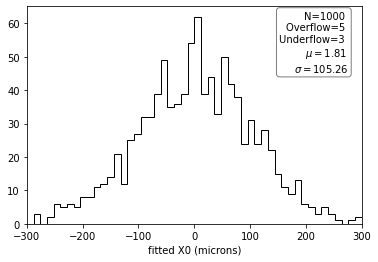

In [7]:
# Plot the fitted value
ax33 = plt.subplot(111)
con33, bins33, _ = ax33.hist(fitVertex, np.linspace(-300.,300.,51), histtype='step', color='black')
statBox(ax33, fitVertex, bins33)
ax33.set_xlim(bins33[0], bins33[-1])
_ = ax33.set_xlabel("fitted X0 (microns)")

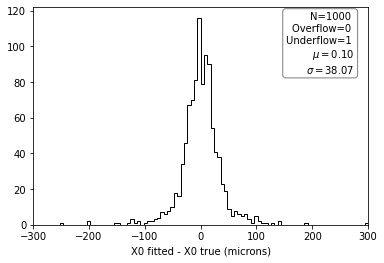

In [8]:
# Plot the difference between the fitted and true vertex
ax3 = plt.subplot(111)
dxfit = fitVertex - 10000*xv
con3, bins3, _ = ax3.hist(dxfit, np.linspace(-300.,300.,101), histtype='step', color='black')
statBox(ax3, dxfit, bins3)
ax3.set_xlim(bins3[0], bins3[-1])
_ = ax3.set_xlabel("X0 fitted - X0 true (microns)")

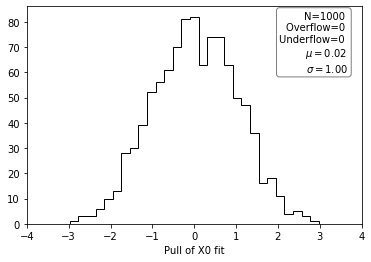

In [9]:
# Plot the pull
ax4 = plt.subplot(111)
con4, bins4, _ = ax4.hist(pull, np.linspace(-4.,4.,40), histtype='step', color='black')
statBox(ax4, pull, bins3)
ax4.set_xlim(bins4[0], bins4[-1])
_ = ax4.set_xlabel("Pull of X0 fit")

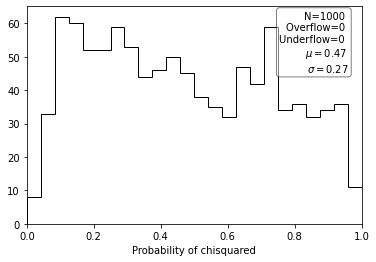

In [10]:
# Plot the chisquared probability 
probAx = plt.subplot(111)
probContents, probBins, _ = probAx.hist(chiProb, np.linspace(0.,1.,25), histtype='step', color='black')
statBox(probAx, chiProb, probBins)
probAx.set_xlim(probBins[0], probBins[-1])
_ = probAx.set_xlabel("Probability of chisquared")